In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 8]
def barplot(labels=[], y_val=[], mn="None", yscale="log"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=7, rotation=30)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' by executable')
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=()):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=7, rotation=30)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' by executable')
    plt.ylim(ylim)
    plt.show()



In [9]:
from models import *
import settings

set_sql_debug(True)
db.bind(**settings.db_params)
# provider='postgres',user='postgres',password='example',host='localhost',dbname='EPMT')
db.generate_mapping(create_tables=True)


BindingError: Database object was already bound to PostgreSQL provider

Job found: CM4_piControl_C_atmos_level_00050101 19917749.moab01.princeton.rdhpcs.noaa.gov


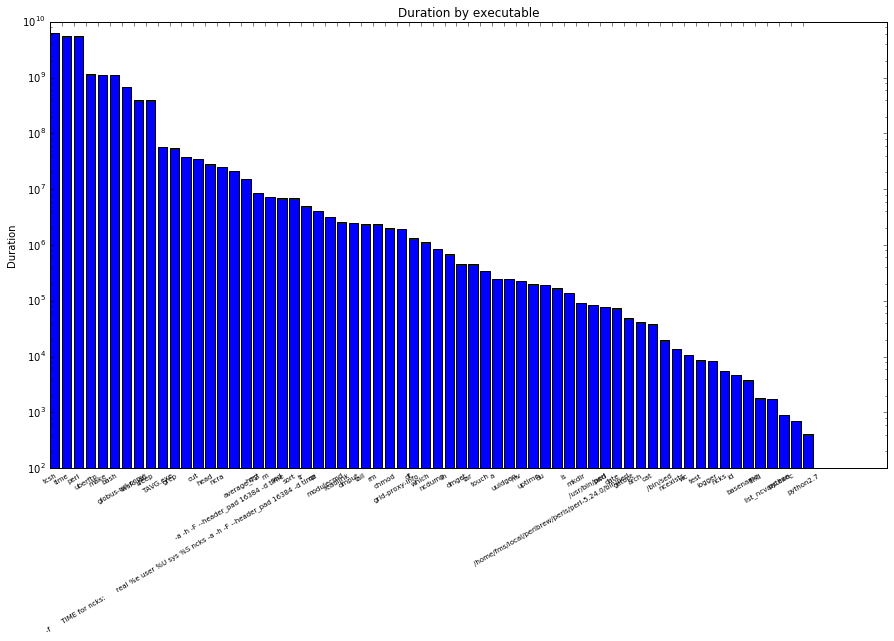

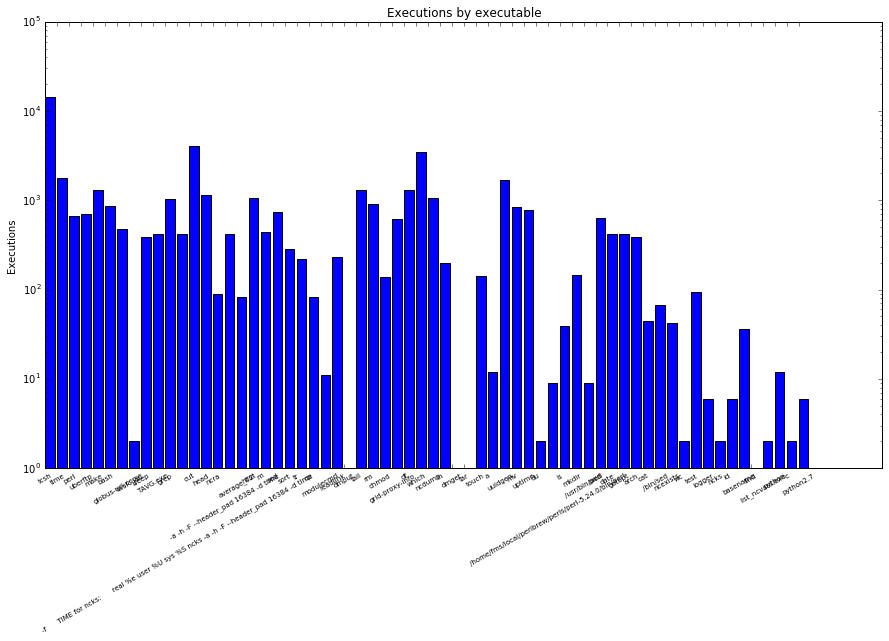

In [10]:
jobid='19917749.moab01.princeton.rdhpcs.noaa.gov'
jobs=select(j for j in Job if j.jobid == jobid)
for j in jobs:
    print "Job found:",j.jobname, j.jobid

processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels

labels = [p[0] for p in processes]
y_val = [p[1] for p in processes]
barplot(labels=labels,y_val=y_val,mn="Duration")

labels = [p[0] for p in processes]
y_val = [p[2] for p in processes]
barplot(labels=labels,y_val=y_val,mn="Executions")




In [14]:
#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





0 cancelled_write_bytes had no non-zero values
1 delayacct_blkio_time
[u'which']
[40000.0]
2 guest_time had no non-zero values
3 inblock had no non-zero values
4 invol_ctxsw
[u'which']
[9816.0]
5 majflt had no non-zero values
6 minflt
[u'which']
[4566495.0]
7 num_threads
[u'which']
[3513.0]
8 outblock had no non-zero values
9 PERF_COUNT_SW_CPU_CLOCK
[u'which']
[843797973.0]
10 processor
[u'which']
[807.0]
11 rchar
[u'which']
[194389063.0]
12 rdtsc_duration
[u'which']
[3749354586.0]
13 read_bytes had no non-zero values
14 rssmax
[u'which']
[71700180.0]
15 starttime
[u'which']
[1.488376285323e+16]
16 syscr
[u'which']
[312615.0]
17 syscw
[u'which']
[1560.0]
18 systemtime
[u'which']
[21216183.0]
19 time_oncpu
[u'which']
[45868818986.0]
20 timeslices
[u'which']
[29121.0]
21 time_waiting
[u'which']
[180827674.0]
22 usertime
[u'which']
[22637848.0]
23 vol_ctxsw
[u'which']
[15774.0]
24 wchar
[u'which']
[1329120.0]
25 write_bytes had no non-zero values


128
64 [(u'a', 249511.0, u'systemtime', 99979.0)]
[(u'a', 249511.0, u'usertime', 170967.0)]


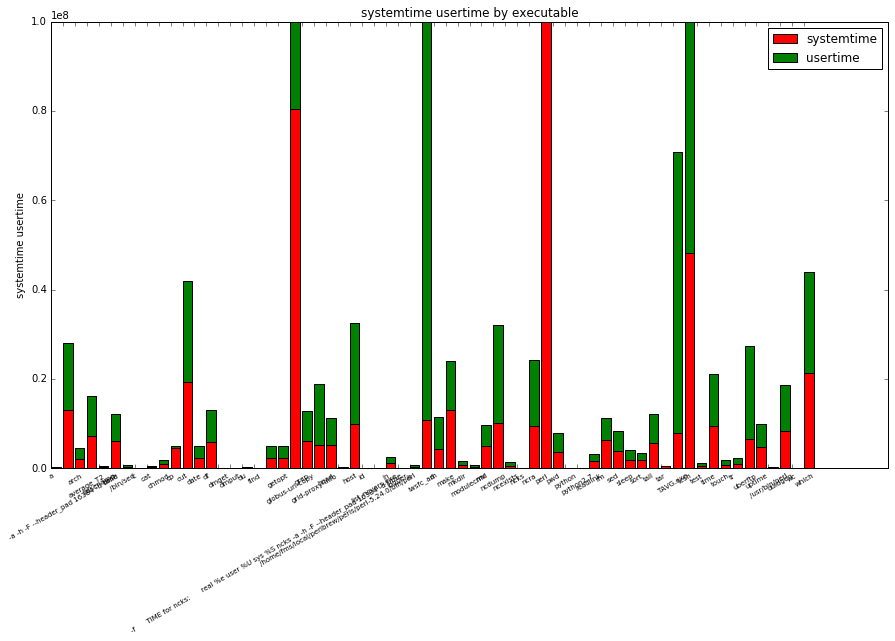

In [60]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [17]:
print len(values[:])

3512


In [7]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

AttributeError: 'tuple' object has no attribute 'threads'

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 